<a href="https://colab.research.google.com/github/jdh4/resnet50/blob/master/day5_computer_vision_hackathon_notebook2_SOLUTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction to Machine Learning  
**Computer Vision Hackathon  
Wintersession  
Tuesday, January 24, 2023**

In this notebook you will create a CNN from scratch to distinguish cats from dogs.

# About Your Colab Session

Learn about the CPU-cores for your session:

In [ ]:
cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs mmio_stale_data retbleed
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtua

In [ ]:
import os
num_cores = min(os.cpu_count(), 2)
print(num_cores)

2


Let's see which GPU we are using (probably a Tesla T4):

In [ ]:
!nvidia-smi

Tue Jan 24 04:00:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    30W /  70W |  14818MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data Preparation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from PIL import Image

We want to use a GPU when one is available:

In [ ]:
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [ ]:
torch.manual_seed(42)
device = torch.device("cuda") if use_cuda else torch.device("cpu")

train_kwargs = {'batch_size': 64}
test_kwargs  = {'batch_size': 1000}
if use_cuda:
    cuda_kwargs = {'num_workers': num_cores, 'pin_memory': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

Download and unpack the data:

In [ ]:
!wget https://tigress-web.princeton.edu/~jdh4/cats_vs_dogs.tar
!tar xf cats_vs_dogs.tar

--2023-01-24 04:00:15--  https://tigress-web.princeton.edu/~jdh4/cats_vs_dogs.tar
Resolving tigress-web.princeton.edu (tigress-web.princeton.edu)... 128.112.173.29
Connecting to tigress-web.princeton.edu (tigress-web.princeton.edu)|128.112.173.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47882240 (46M) [application/x-tar]
Saving to: ‘cats_vs_dogs.tar.4’

cats_vs_dogs.tar.4  100%[===================>]  45.66M  68.2MB/s    in 0.7s    

2023-01-24 04:00:16 (68.2 MB/s) - ‘cats_vs_dogs.tar.4’ saved [47882240/47882240]



In [ ]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])
dataset1 = datasets.ImageFolder(root="./training_set/", transform=transform)
dataset2 = datasets.ImageFolder(root="./test_set/", transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1, shuffle=True, **train_kwargs)
test_loader  = torch.utils.data.DataLoader(dataset2, shuffle=True, **test_kwargs)

There are roughly 4000 cat images and 4000 dog images in the training set. The test set is roughly 1000 images of each. All images have dimensions 128x128. The cat and dogs images are in color so they are composed of three layers (red, green, blue). The MNIST data set was grayscale so only a single layer was needed per image.

Image height: 128
Image width: 128


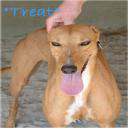

In [ ]:
img = Image.open("./training_set/dogs/resized-dog.1001.jpg")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

Image height: 128
Image width: 128


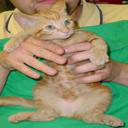

In [ ]:
img = Image.open("./training_set/cats/resized-cat.1001.jpg")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

# Model Definition and Hackathon Project

The hackathon project is to create a convolutional neural network from scratch and train int such that it gives a sustained accuracy of 75% or higher on the test set. Your network should use at least 3 convolutional layers.

You only need to write the Net class. The rest of the notebook does not need to be changed. After writing the Net class, try running notebook. Raise your hand if you have any questions for the instructor. We're happy to give hints as you work through the exercise.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CREATE THE LAYERS HERE
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 32, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout3 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(28800, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        # DEFINE THE FORWARD PASS HERE
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout3(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

Instantiate the network and move it to the device (which is a GPU when available). Create the optimizer.

In [ ]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1.0)

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 126, 126]             896
            Conv2d-2         [-1, 64, 124, 124]          18,496
           Dropout-3           [-1, 64, 62, 62]               0
            Conv2d-4           [-1, 32, 60, 60]          18,464
           Dropout-5           [-1, 32, 30, 30]               0
            Linear-6                  [-1, 128]       3,686,528
           Dropout-7                  [-1, 128]               0
            Linear-8                    [-1, 2]             258
Total params: 3,724,642
Trainable params: 3,724,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 14.36
Params size (MB): 14.21
Estimated Total Size (MB): 28.76
----------------------------------------------------------------


# Train and Test Methods

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train() # sets the model in training mode (i.e., dropout enabled)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def test(model, device, test_loader):
    model.eval() # sets the model in evaluation mode (i.e., dropout disabled)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Train for some number of epochs while reporting the accuracy on the test set periodically:

In [ ]:
epochs = 12
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/8005 (0%)]	Loss: 0.711330
Train Epoch: 1 [6400/8005 (79%)]	Loss: 0.650498

Test set: Average loss: 0.6569, Accuracy: 1267/2023 (63%)

Train Epoch: 2 [0/8005 (0%)]	Loss: 0.679099
Train Epoch: 2 [6400/8005 (79%)]	Loss: 0.673493

Test set: Average loss: 0.6393, Accuracy: 1259/2023 (62%)

Train Epoch: 3 [0/8005 (0%)]	Loss: 0.646635
Train Epoch: 3 [6400/8005 (79%)]	Loss: 0.538871

Test set: Average loss: 0.5943, Accuracy: 1355/2023 (67%)

Train Epoch: 4 [0/8005 (0%)]	Loss: 0.636675
Train Epoch: 4 [6400/8005 (79%)]	Loss: 0.418632

Test set: Average loss: 0.5415, Accuracy: 1466/2023 (72%)

Train Epoch: 5 [0/8005 (0%)]	Loss: 0.366006
Train Epoch: 5 [6400/8005 (79%)]	Loss: 0.447507

Test set: Average loss: 0.5410, Accuracy: 1466/2023 (72%)

Train Epoch: 6 [0/8005 (0%)]	Loss: 0.482679
Train Epoch: 6 [6400/8005 (79%)]	Loss: 0.489905

Test set: Average loss: 0.5256, Accuracy: 1485/2023 (73%)

Train Epoch: 7 [0/8005 (0%)]	Loss: 0.562337
Train Epoch: 7 [6400/8005 (79%)]	Loss: 0.444